In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
print(sys.version)

3.7.9 (default, Oct 18 2020, 22:55:02) 
[Clang 10.0.1 (clang-1001.0.46.4)]


In [336]:
import glob

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import display, Audio
from matplotlib import pyplot as plt
from nesmdb.convert import midi_to_wav
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import (
    pack_padded_sequence, pad_packed_sequence, pad_sequence,
)
from tqdm.notebook import trange, tqdm

import utils

In [4]:
torch.manual_seed(1);

In [356]:
DATA_ROOT = "data/nesmdb_token"
TRAIN_DIR = f"{DATA_ROOT}/train"
VALID_DIR = f"{DATA_ROOT}/valid"
TEST_DIR = f"{DATA_ROOT}/test"

VOCAB_PATH = "data/vocab.txt"

CHECKPOINT_PATH = "models/checkpoint.pt"

In [6]:
train_files = glob.glob(f"{TRAIN_DIR}/*.txt")
valid_files = glob.glob(f"{VALID_DIR}/*.txt")
test_files = glob.glob(f"{TEST_DIR}/*.txt")

vocab = utils.load_data(VOCAB_PATH)
token_to_index = {token: i for i, token in enumerate(vocab)}

VOCAB_SIZE = len(vocab)
print(f"Vocab size: {VOCAB_SIZE}")

Vocab size: 632


In [27]:
def to_tensor(tokens):
    """Convert a list of tokens to a tensor of indices."""
    return torch.LongTensor([token_to_index[token] for token in tokens])

def to_tokens(tensor):
    """Convert a tensor of indices to a list of tokens."""
    return [vocab[i] for i in tensor.tolist()]

In [412]:
class MusicGenerator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, rnn_type="gru", num_layers=1):
        assert rnn_type in ["gru", "lstm"]

        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.rnn_type = rnn_type
        self.num_layers = num_layers

        self.embeddings = nn.Embedding(input_size, hidden_size)
        self.rnn = (
            nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True) if rnn_type == "lstm"
            else nn.GRU(hidden_size, hidden_size, num_layers, batch_first=True)
        )
        self.fc = nn.Linear(self.hidden_size, self.output_size)
        
        self.hidden_state = None

    def forward(self, x, reset_hidden_state=True):
        # Note: Instead of using a one-hot encoding for each token and then
        # multiplying it by a weight matrix, we directly store an embedding
        # for every token in x. This is equivalent but speeds up computation.
        x = self.embeddings(x)
                
        # Pack the padded embeddings
        # x = pack_padded_sequence(
        #     x,
        #     lengths=seq_lens,
        #     batch_first=True,
        #     enforce_sorted=False,
        # )
        
        # Add fake batch dimension
        x = x.unsqueeze(0)

        # Forward pass through RNN and FC layer.
        if reset_hidden_state:
            x, _ = self.rnn(x)
        else:
            x, self.hidden_state = self.rnn(x, self.hidden_state)
                
        # Undo packing.
        # x, _ = pad_packed_sequence(x, batch_first=True)
        
        # Map to output space
        x = self.fc(x)
        
        # Remove fake batch dimension
        x = x.squeeze(0)

        return x

In [413]:
HIDDEN_SIZE = 64
NUM_EPOCHS = 250
LEARNING_RATE = 1e-3
LOG_EVERY_N = 1
SAVE_EVERY_N = 1

In [414]:
model = MusicGenerator(
    input_size=VOCAB_SIZE,
    hidden_size=HIDDEN_SIZE,
    output_size=VOCAB_SIZE,
    rnn_type="lstm",
    num_layers=1,
)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [415]:
# Load the first k elements of the first n training files
k = 5000
n = 100
train_data = [
    to_tensor(utils.load_data(file)[:k])
    for file in train_files[:n]
]

# data_loader = DataLoader(
#     train_data,
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     collate_fn=lambda x: x,
#     num_workers=0,
# )

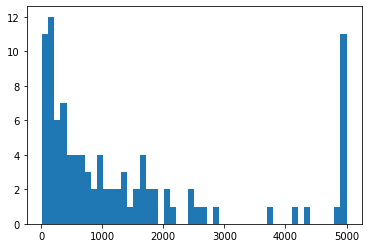

In [416]:
seq_lens = [len(seq) for seq in train_data]
plt.hist(seq_lens, bins=50)
plt.show()

In [417]:
for epoch in range(1, NUM_EPOCHS + 1):
    total_loss = 0.0
    for seq in tqdm(train_data):
        # Reset gradients.
        model.zero_grad()
        
        # Prepare inputs and targets. In this implementation, we
        # ignore the EOS token at the end of the sequence.
        x = seq[:-2] 
        y = seq[1:-1]
                
        # Forward prop.
        y_hat = model(x)
        
        # Compute loss.
        loss = loss_function(y_hat, y)
        total_loss += loss.item()

        # Back prop.
        loss.backward()
        
        # Update parameters.
        optimizer.step()
        
    if epoch % LOG_EVERY_N == 0:
        avg_loss = total_loss / len(seq)
        print(f"Epoch: {epoch} \t Avg loss: {avg_loss}")
    
    if epoch % SAVE_EVERY_N == 0:
        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
            },
            CHECKPOINT_PATH,
        )


Epoch: 1 	 Avg loss: 1.1884727004974607


KeyboardInterrupt: 

In [366]:
def validate(model, dataset):
    with torch.no_grad(): 
        total_loss = 0.0
        for seq in tqdm(dataset):
            x = seq[:-1]
            y = seq[1:]
            y_hat = model(x)
            loss = loss_function(y_hat, y)
            total_loss += loss.item()
        avg_loss = total_loss / len(seq)
        return avg_loss

In [447]:
T = 0.2

def generate_next_token(model, next_input, reset_hidden=False):
    model_input = to_tensor(next_input)
    model_output = model(model_input, reset_hidden)
    # We're scaling the logits by a parameter T, which can increase
    # (T < 1) or decrease (T > 1) the entropy of the softmax
    # distribution.
    next_token_probs = F.softmax(model_output[-1] / T, dim=0)
    next_token = np.random.choice(vocab, p=next_token_probs.numpy())
    return next_token


def generate_song(model, seq_start=None, max_length=1000):
    if not seq_start:
        seq_start = ["BOS"]
    seq = seq_start.copy()
    with torch.no_grad():
        next_token = generate_next_token(model, seq, reset_hidden=True)
        while len(seq) <= max_length:
            next_token = generate_next_token(
                model,
                next_input=[next_token],
                reset_hidden=False,
            )
            seq.append(next_token)
    return seq

In [448]:
song = generate_song(model, max_length=1500)

In [449]:
def remove_special_tokens(token_seq):
    return [t for t in token_seq if t != "BOS" and t != "EOS"]

In [450]:
SAMPLE_RATE = 44100

song = remove_special_tokens(song)
midi = utils.event_to_midi(song)
wav = midi_to_wav(midi, midi_to_wav_rate=100)

display(Audio(wav[:SAMPLE_RATE * 10], rate=SAMPLE_RATE))

In [30]:
song = to_tokens(train_data[1])
song = remove_special_tokens(song)
midi = utils.event_to_midi(song)
wav = midi_to_wav(midi, midi_to_wav_rate=100)

display(Audio(wav[:SAMPLE_RATE * 10], rate=SAMPLE_RATE))